# Quantifying SAM's performance on binary segmentation of crops in satellite imagery using CDL-imformed prompting

* File Created: Monday, 18th September 2023 4:15:14 pm
* Author: Rutuja Gurav (rgura001@ucr.edu)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.device_count())

1.13.1
True
8


In [3]:
import sklearn
print(sklearn.__version__)

0.22.2.post1


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor']='white'
import seaborn as sns
sns.set(rc={'axes.facecolor':'white', 
            'figure.facecolor':'white',
        })

from scipy import ndimage
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm
import sys, glob, os, collections
from pprint import pprint

import utils

## Download SAM weights

Find explanation of SAM's parameters here - 
(SAM paper) https://arxiv.org/abs/2304.02643
(Blog) https://replicate.com/pablodawson/segment-anything-automatic

In [4]:
# !wget --directory-prefix=cached_models https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
# !wget --directory-prefix=cached_models https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth
# !wget --directory-prefix=cached_models https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

--2023-06-20 16:57:20--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.225.142.88, 13.225.142.76, 13.225.142.121, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.225.142.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘cached_models/sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G  94.2MB/s    in 23s     

2023-06-20 16:57:43 (106 MB/s) - ‘cached_models/sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]

--2023-06-20 16:57:44--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.225.142.88, 13.225.142.76, 13.225.142.121, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.225.142.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1249524607 (1.2G) [

## Example: Segmenting CalCrop21 Images

CalCrop21[1] is a benchmark dataset that contained 4D spatiotemporal multispectral tiles of satellite imagery from Sentinel-2 satellite for the year 2018 for Central Valley, CA agricultural fields along with the corresponding ground-truth crop-map (CDL) for each tile. As SAM is limited to 3-channel RGB inputs, we have to use RGB channels from an appropriate timestep in the year. We have decided this appropriate timestep to be the maximum NDVI timestep.  

[1] Ghosh, Rahul, et al. "Calcrop21: A georeferenced multi-spectral dataset of satellite imagery and crop labels." 2021 IEEE International Conference on Big Data (Big Data). IEEE, 2021.

### Visualize Samples

In [60]:
aoi_sizes = [1098, 549, 274, 137, 68]
aoi_size = aoi_sizes[3]
SAMPLES_DIR = "/data/rgura001/AI4CP.data/sam4crops/aoi_samples/overlap_0.5/DATAPOINTS_maxNDVItimestep_rgb_size_{}".format(aoi_size)
sample_filepaths = sorted(glob.glob(SAMPLES_DIR+"/*.npy"))
print(len(sample_filepaths), sample_filepaths[:2])

78075 ['/data/rgura001/AI4CP.data/sam4crops/aoi_samples/overlap_0.5/DATAPOINTS_maxNDVItimestep_rgb_size_137/T10SEH_2018_1_9_sample_0_maxNDVItimestep_rgb_size_137.npy', '/data/rgura001/AI4CP.data/sam4crops/aoi_samples/overlap_0.5/DATAPOINTS_maxNDVItimestep_rgb_size_137/T10SEH_2018_1_9_sample_100_maxNDVItimestep_rgb_size_137.npy']


In [6]:
num_samples=10
num_avail_samples = len(sample_filepaths)
if num_avail_samples >= num_samples:
    np.random.seed(42)
    sample_idxes = np.random.randint(low=0, high=num_avail_samples, size=num_samples)
else:
    print("num_samples greater than num_avail_samples(={})! Exiting...".format(num_avail_samples))
    # sys.exit()
print(sample_idxes)

[102 270 106  71 188  20 102 121 214 330]


102 (1098, 1098, 4)
(1098, 1098, 3) (1098, 1098)


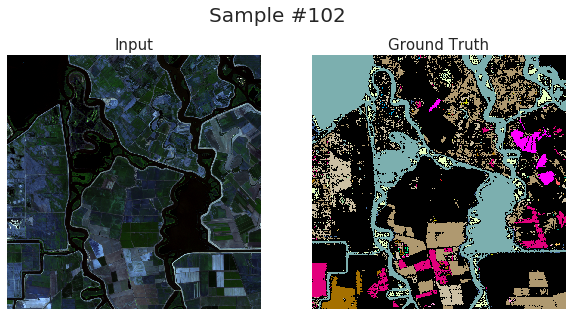

In [42]:
i = 0
sample_id = sample_idxes[i]
sample = np.load(sample_filepaths[sample_id])    
print(sample_idxes[i], sample.shape)

image, gt_mask = sample[...,:3].astype('uint8'), sample[...,-1] ## because SAM expects uint8 inputs
print(image.shape, gt_mask.shape)

utils.plot_sample(img=image, mask=gt_mask, titlestr=f"Sample #{sample_id}")

### Convert multi-class mask to a set of binary masks

The input to `SamPredictor` is (`point_coords`, `point_labels`) where,

- `point_coords` (np.ndarray or None): A Nx2 array of point prompts to the model. Each point is in (X,Y) in pixels.

- `point_labels` (np.ndarray or None): A length N array of labels for the point prompts. 1 indicates a foreground point and 0 indicates a background point.

#### Steps to get this from CDL

1. Convert CDL to multiple binary masks by one-hot encoding the CDL.
2. For each class, sample coords of some 1s from the binary class mask. 

In [8]:
# dict(sorted(dict(collections.Counter(gt_mask.flatten())).items(), key=lambda item: item[1], reverse=True))

In [9]:
cdl_binary_masks = np.array([np.where(gt_mask==i, 1, 0) \
                       for i in np.unique(gt_mask)])
crop_ids = list(np.unique(gt_mask))
print(cdl_binary_masks.shape)
print(crop_ids)

(21, 1098, 1098)
[0, 2, 3, 5, 6, 7, 9, 11, 13, 14, 16, 17, 19, 20, 21, 22, 24, 25, 26, 27, 100]


In [10]:
counts_dict = {}
for i, crop_id in enumerate(crop_ids):
    counts_dict[crop_id] = np.count_nonzero(cdl_binary_masks[i,:,:])
counts_dict = dict(sorted(counts_dict.items(), key=lambda item: item[1], reverse=True))
counts_dict

{0: 348508,
 100: 348234,
 26: 243219,
 19: 122304,
 22: 49038,
 5: 35357,
 25: 23167,
 6: 15713,
 11: 13118,
 27: 2478,
 24: 1169,
 20: 922,
 3: 423,
 7: 398,
 9: 351,
 17: 335,
 16: 285,
 14: 209,
 2: 198,
 13: 168,
 21: 10}

In [11]:
crop_ids_reverse_sorted_by_pixel_count = list(counts_dict.keys())
print(crop_ids_reverse_sorted_by_pixel_count)

[0, 100, 26, 19, 22, 5, 25, 6, 11, 27, 24, 20, 3, 7, 9, 17, 16, 14, 2, 13, 21]


### Get Predictions

#### Setup SAM

In [12]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

MODEL_DIR = "/home/rgura001/segment-anything/sam4crops/cached_models"
model_type = "vit_h"
sam_checkpoint = [fp for fp in glob.glob(MODEL_DIR+'/*.pth') if model_type in fp][0]
print(sam_checkpoint)
device = "cuda:7"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint).to(device=device)

/home/rgura001/segment-anything/sam4crops/cached_models/sam_vit_h_4b8939.pth


#### SAM Predictor

Full explanation of all options available in `SamPredictor` can be found here - 
https://github.com/facebookresearch/segment-anything/blob/main/segment_anything/predictor.py

In [13]:
predictor = SamPredictor(sam)
predictor.set_image(image)

In [14]:
pos_prompts_only  = True
nth_largest = 2
cdl_label = crop_ids_reverse_sorted_by_pixel_count[nth_largest]
print(cdl_label)
pos_bin_mask = cdl_binary_masks[crop_ids.index(cdl_label),:,:]
neg_bin_mask = cdl_binary_masks[crop_ids.index(100),:,:] #+ cdl_binary_masks[crop_ids.index(0),:,:]
print(pos_bin_mask.shape, np.unique(pos_bin_mask))
print(neg_bin_mask.shape, np.unique(neg_bin_mask))

pos_prompt_coords = np.argwhere(pos_bin_mask==1)[:,[1,0]]
pos_prompt_labels = np.ones(len(pos_prompt_coords)).astype(int)
print(pos_prompt_coords.shape, pos_prompt_labels.shape)
print(pos_prompt_coords[:2], pos_prompt_labels[:2])

neg_prompt_coords = np.argwhere(neg_bin_mask==1)[:,[1,0]]
neg_prompt_labels = np.zeros(len(neg_prompt_coords)).astype(int)
print(neg_prompt_coords.shape, neg_prompt_labels.shape)
print(neg_prompt_coords[:2], neg_prompt_labels[:2])

pos_prompt_coords_sample_idxes = np.random.choice(range(len(pos_prompt_labels)), 100)
neg_prompt_coords_sample_idxes = np.random.choice(range(len(neg_prompt_labels)), 100)


if pos_prompts_only:
    input_points = pos_prompt_coords[pos_prompt_coords_sample_idxes]
    input_labels = pos_prompt_labels[pos_prompt_coords_sample_idxes]
else:
    input_points = np.concatenate([pos_prompt_coords[pos_prompt_coords_sample_idxes], 
                               neg_prompt_coords[neg_prompt_coords_sample_idxes]])
    input_labels = np.concatenate([pos_prompt_labels[pos_prompt_coords_sample_idxes], 
                                neg_prompt_labels[neg_prompt_coords_sample_idxes]])

print(input_points.shape, input_labels.shape)
print(input_points[:2], input_labels[:2])

pos_bin_mask_cdl = pos_bin_mask * cdl_label
neg_bin_mask_cdl = neg_bin_mask * 100
print(pos_bin_mask_cdl.shape, np.unique(pos_bin_mask_cdl))
print(neg_bin_mask_cdl.shape, np.unique(neg_bin_mask_cdl))

26
(1098, 1098) [0 1]
(1098, 1098) [0 1]
(243219, 2) (243219,)
[[0 0]
 [1 0]] [1 1]
(348234, 2) (348234,)
[[263   0]
 [264   0]] [0 0]
(100, 2) (100,)
[[110 217]
 [810 327]] [1 1]
(1098, 1098) [ 0 26]
(1098, 1098) [  0 100]


In [15]:
masks, iou_predictions, low_res_masks = predictor.predict(
    point_coords=input_points,
    point_labels=input_labels,
    multimask_output=False,
    
)
print(masks.shape)
print(iou_predictions)
print(low_res_masks.shape)

(1, 1098, 1098)
[0.6159624]
(1, 256, 256)


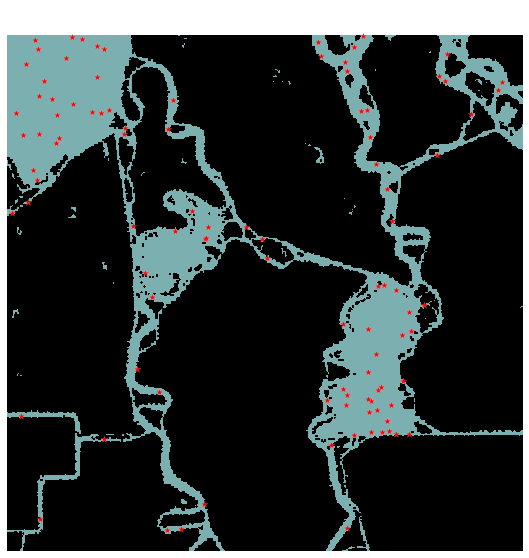

In [16]:
import utils
plt.figure(figsize=(10,10))
plt.imshow(utils.colormap_mask(np.vectorize(utils.labels_cdl_map.get)(pos_bin_mask_cdl)))
# plt.imshow(bin_mask, cmap='gray')
# utils.show_mask(masks[1], plt.gca())
utils.show_points(input_points, input_labels, plt.gca())
plt.axis('off')
plt.show() 

In [29]:
print(masks[0].shape, pos_bin_mask.shape)
print(np.unique(masks[0].astype(int)), np.unique(pos_bin_mask))


(1098, 1098) (1098, 1098)
[0 1] [0 1]


In [46]:
print("Evaluating clustering consensus...")
clust_score = utils.eval_clustering(labels_true=pos_bin_mask.flatten(), 
                                    labels_pred=masks[0].astype(int).flatten())
print("DONE!")

print("Calculating Dice Overlap and IoU...")
claswise_dice_coeff, mean_dice_coeff = utils.multiclass_dice_overlap(true_mask=pos_bin_mask, 
                                           predicted_mask=masks[0].astype(int))
classwise_iou, mean_iou = utils.multiclass_iou(true_mask=pos_bin_mask,
                            predicted_mask=masks[0].astype(int))
print("DONE!")

Evaluating clustering consensus...
DONE!
Calculating Dice Overlap and IoU...
DONE!


Plotting...


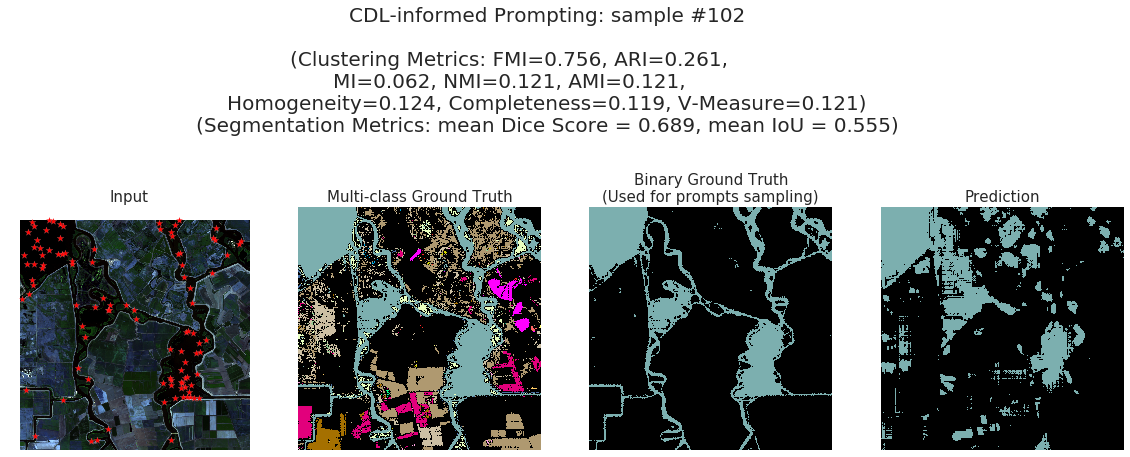

In [55]:
print("Plotting...")
titlestr=f"CDL-informed Prompting: sample #{sample_id}\n"
titlestr += f"\n(Clustering Metrics: FMI={clust_score['FMI']}, ARI={clust_score['ARI']},\
            \nMI={clust_score['MI']}, NMI={clust_score['NMI']}, AMI={clust_score['AMI']},\
            \nHomogeneity={clust_score['Homogeneity']}, Completeness={clust_score['Completeness']}, V-Measure={clust_score['V-Measure']})"
titlestr += f"\n(Segmentation Metrics: mean Dice Score = {np.round(mean_dice_coeff, 3)}, mean IoU = {np.round(mean_iou, 3)})"

utils.plot_bin_prediction(input=image,
                          bin_mask_cdl=pos_bin_mask_cdl,
                          gt_mask=gt_mask,
                          pred_mask=masks[0],
                          input_points=input_points,
                          input_labels=input_labels,
                          # titlestr=f"CDL-informed Prompting: (Crop Label - {utils.labels_class_map[cdl_label]})",
                          titlestr=titlestr,
                          show=True, save=False,
                        )

In [54]:
np.unique((pos_bin_mask_cdl))[-1]

26

#### [TESTING] Grid Search

#### SAM Automatic Mask Generator: Uniformly distrubted Prompts

Full explanation of all options available in `SamAutomaticMaskGenerator` can be found here - https://github.com/facebookresearch/segment-anything/blob/main/segment_anything/automatic_mask_generator.py

  0%|          | 0/1 [00:00<?, ?it/s]

1 1
Defining mask generator...
DONE!
Generating masks...
For sample 102, SAM generated 237 boolean masks!
Max cluster id = 237
num_labels_in_pred_mask = 183
DONE!
Evaluating clustering consensus...
DONE!
Plotting...


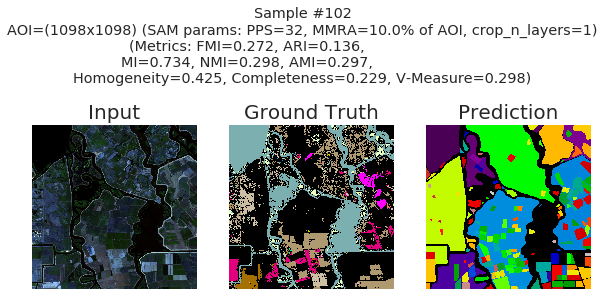

DONE!


In [50]:
from utils import plot_prediction, eval_clustering

img_w, img_h = aoi_size, aoi_size
min_mask_region_fracs_vals = [1e-1]
# min_mask_area_vals = [int(min_mask_area_frac*img_w*img_h) for min_mask_area_frac in min_mask_region_frac_vals]
pps_vals = [32]
crop_n_layers_vals = [1]
crop_n_points_downscale_factor = 1

for pps in pps_vals:
    for min_mask_area_frac in tqdm(min_mask_region_fracs_vals, leave=False):
        min_mask_area = int(min_mask_area_frac*img_w*img_h)
        min_mask_area_perc = min_mask_area_frac*100
        for crop_n_layers in crop_n_layers_vals:
            # for crop_n_points_downscale_factor in crop_n_points_downscale_factor_vals:
            # try:
            print(crop_n_layers, crop_n_points_downscale_factor)
            
            titlestr = "AOI=({}x{}) (SAM params: PPS={}, MMRA={}% of AOI, crop_n_layers={})"\
                        .format(img_w, img_h, pps, min_mask_area_perc, crop_n_layers)
            # print(titlestr)

            print("Defining mask generator...")
            mask_generator = SamAutomaticMaskGenerator(model=sam,
                                                        points_per_side=pps,
                                                        pred_iou_thresh=0.95,
                                                        stability_score_thresh=0.95,
                                                        # box_nms_thresh=0.0,
                                                        # crop_nms_thresh=0.0,
                                                        crop_n_layers=crop_n_layers,
                                                        crop_n_points_downscale_factor=crop_n_points_downscale_factor,
                                                        min_mask_region_area=min_mask_area,  # Requires open-cv to run post-processing
                                                    )
            print("DONE!")

            print("Generating masks...")
            masks = mask_generator.generate(image)
            # print(masks[0].keys())
            print("For sample {}, SAM generated {} boolean masks!".format(sample_id, len(masks)))
            ## Sort masks by stability score
            masks = sorted(masks, key=lambda d: d['stability_score']) 

            ## How many pixels got no mask?
            # pred_mask = np.logical_or.reduce(np.array([mask['segmentation'] for mask in masks]), axis=0)
            # print(pred_mask.shape)
            # print(collections.Counter(pred_mask.flatten()))

            ## Checking for any overlap in the masks
            # bin_masks = np.array([np.array(mask['segmentation']).astype(int) for mask in masks])
            # print(collections.Counter(bin_masks.flatten()))
            # pred_mask = np.sum(bin_masks, axis=0)
            # print(pred_mask.shape)
            # print(collections.Counter(pred_mask.flatten()))

            ## Transform N boolean overlapping masks into one numerically encoded mask
            pred_mask = np.zeros((image.shape[0], image.shape[1]))
            # pred_mask = masks[0]['segmentation'].astype(int)
            for i in range(len(masks)):
                val = i+1
                pred_mask += masks[i]['segmentation'].astype(int) * val
                pred_mask = np.where(pred_mask > val, val, pred_mask)
            pred_mask = pred_mask.astype('uint8')
            print(f"Max cluster id = {pred_mask.flatten().max()}")
            print(f"num_labels_in_pred_mask = {len(np.unique(pred_mask))}")
            print("DONE!")

            print("Evaluating clustering consensus...")
            clust_score = eval_clustering(labels_true=gt_mask.flatten(), labels_pred=pred_mask.flatten())
            print("DONE!")
            
            print("Plotting...")
            titlestr += f"\n(Metrics: FMI={clust_score['FMI']}, ARI={clust_score['ARI']},\
                        \nMI={clust_score['MI']}, NMI={clust_score['NMI']}, AMI={clust_score['AMI']},\
                        \nHomogeneity={clust_score['Homogeneity']}, Completeness={clust_score['Completeness']}, V-Measure={clust_score['V-Measure']})"
            titlestr = f"Sample #{sample_id}\n"+titlestr
            plot_prediction(input=image, gt_mask=gt_mask, pred_mask=pred_mask, 
                            titlestr=titlestr,
                            show=True, save=False)
            # plot_prediction(input=image, gt_mask=gt_mask, pred_mask=pred_mask, 
            #                 titlestr="",
            #                 show=True, save=False)
            print("DONE!")
            # except Exception as e:
            #     print("Error encountered! Continuing...")
            #     print(e)
            #     continue


In [12]:
# import json_tricks
# masks_dict = {}
# masks_dict[str(sample_id)] = masks
# SAVE_DIR = "/home/rgura001/segment-anything/sam4crops/results/nbk"
# with open(SAVE_DIR+"/predicted_masks.json", "w") as fp:
#     json_tricks.dump(masks_dict, fp)

# masks_dict_loaded = json_tricks.load(open(SAVE_DIR+"/predicted_masks.json", "r"))
# print(dict(masks_dict_loaded).keys())
# print(dict(masks_dict_loaded[str(sample_id)][0]).keys())

In [1]:
# pprint(list(mask_generator.__dict__.keys()))